# Exploring NBA Statistics – Web Scraping for Machine Learning

## 1. Introduction

In this initial part, we're going to complete the first segment of a machine learning project centered around NBA statistics. The NBA, short for [National Basketball Association](https://en.wikipedia.org/wiki/National_Basketball_Association), stands as one of the premier men's basketball leagues globally, boasting a vast fanbase and a rich history.

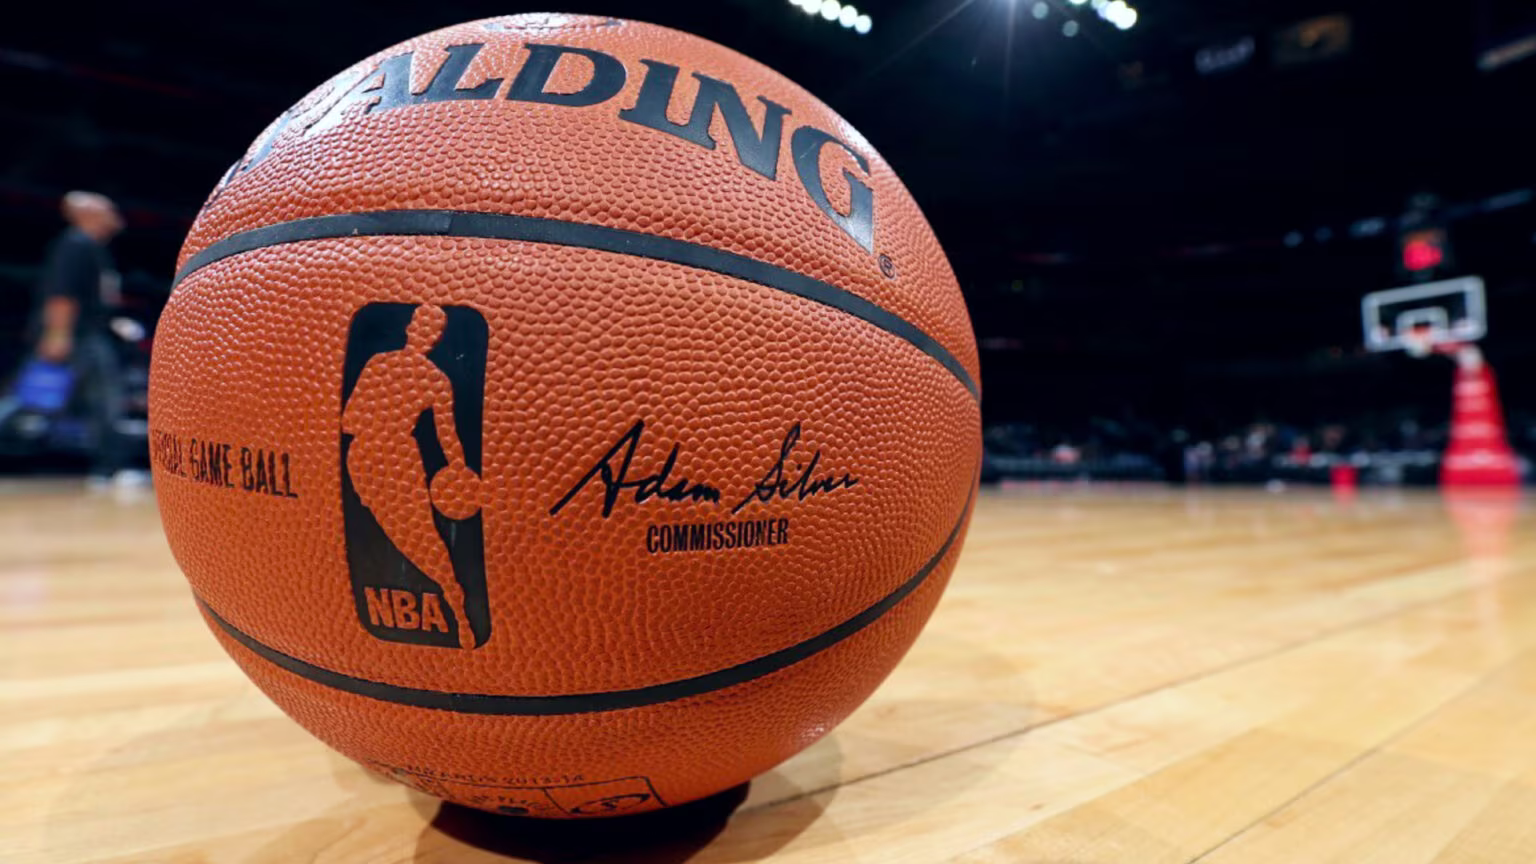

Over time, the NBA has seen a surge in popularity, extending its influence beyond sports into realms like fashion, music, and entertainment. With `30` teams, the NBA is divided into two conferences: the `Eastern Conference` and the `Western Conference`, each further segmented into `3` divisions.

The goal of the machine learning project is to develop a predictive model capable of forecasting the recipient of the [MVP](https://en.wikipedia.org/wiki/Most_valuable_player) (Most Valuable Player) award in a given NBA season. The MVP award holds significant importance, being bestowed upon the player who contributes most significantly to their team's success throughout the season.

Currently, our focus is on gathering the necessary data on NBA players and their statistics, and organizing this data to prepare for subsequent phases.

## 2. Exploring the Pages to Scrape

Let's start by looking for the data we want to obtain. For this purpose, we'll turn to [Basketball Reference](https://www.basketball-reference.com/). This website provides a wealth of structured and well-formatted historical NBA data up to the present. Furthermore, we aim to extract statistics from three different types of pages.

The first type contains data on the MVP for each season. We're interested in NBA statistics dating back from the `2004-2005` season to the current `2023-2024` season (as of this writing). Moreover, we will download the pages for each season and then extract the MVP votes table from each one.

Before scraping web data, it's a good idea to familiarize ourselves with the structure of the data we're going to scrape. The best way to do this is by using the page inspector, which shows the HTML of the page. By highlighting any element, we can see its corresponding HTML as illustrated in the screenshot below:

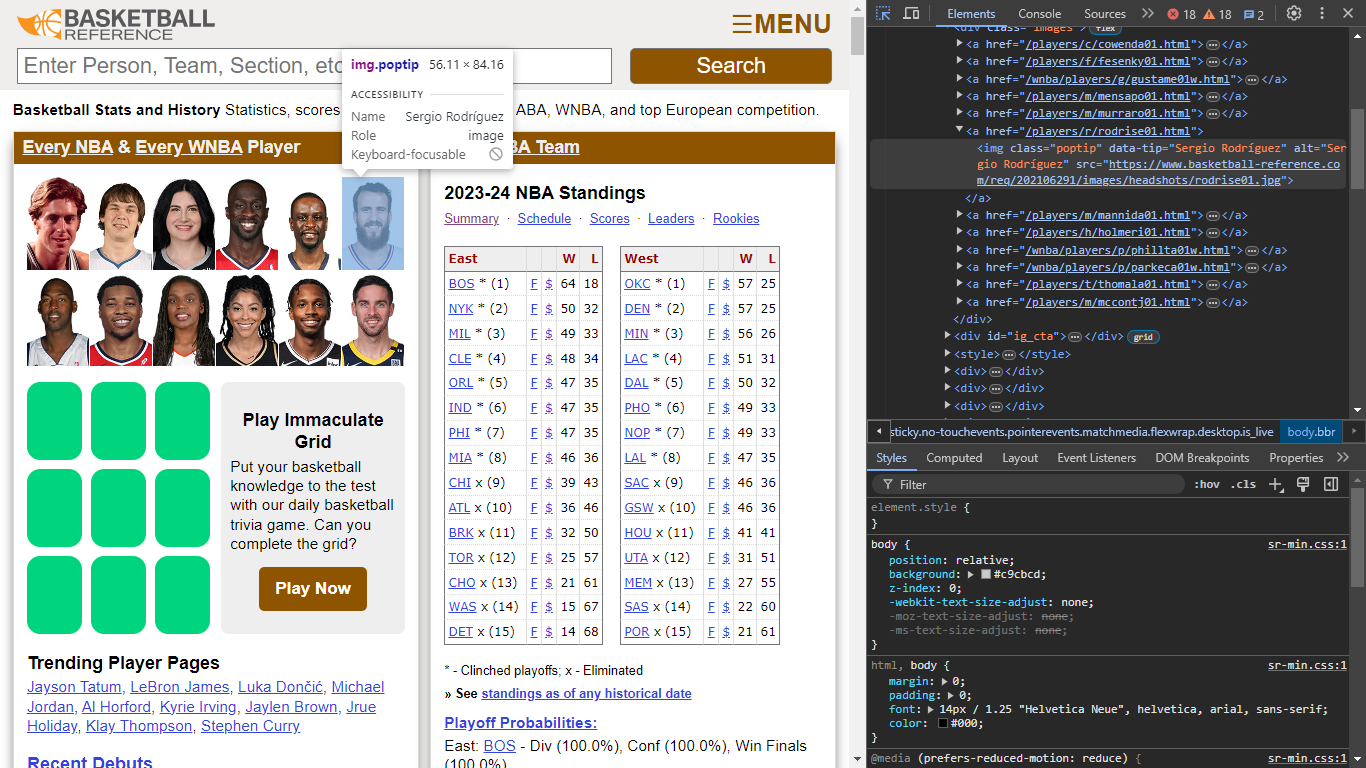

## 3. Downloading MVP Voting Tables

Now that we've explored the structure of the pages with MVP votes, let's download and save those pages. To do so, we're going to use the [Requests](https://requests.readthedocs.io/en/latest/) library, which is designed specifically for downloading web pages. To get started, let's import all the necessary libraries for web scraping, data handling, and parsing HTML.

In [1]:
# Import libraries for web scraping and data handling
import time
import requests
import pandas as pd

# Import libraries for web scraping with Selenium
from selenium import webdriver
from selenium.webdriver.chrome.service import Service

# Import BeautifulSoup for parsing HTML
from bs4 import BeautifulSoup

We'll download and save the pages for the last `20` years, from the `2004-2005` season to the current `2023-2024` season. As a result, we'll have the HTML files containing the MVP voting tables for each season within this period downloaded and saved locally.

In [2]:
# Define the range of years and URL pattern for MVP award pages
years = list(range(2005, 2025))
url_start = "https://www.basketball-reference.com/awards/awards_{}.html"

# Loop through each year in the defined range
for year in years:
    
    # Format the URL with the current year, send a GET request, and store the response
    url = url_start.format(year)
    data = requests.get(url)
    
    # Open a file in write mode to save the HTML content, and write the response text to the file
    with open("MVP/{}.html".format(year), mode="w", encoding="UTF-8") as f:
        f.write(data.text)

We prefer to save HTML files locally because when we parse HTML, we don't want to re-download a webpage every time. This approach will help us avoid making multiple GET requests to the Basketball Reference website every time.

## 4. Parsing and Combining MVP Voting Tables

Now that we have downloaded and saved entire HTML pages for the last `20` seasons locally, we need to extract the MVP voting table from each webpage. To do this, we'll use [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/), a Python library for parsing web pages.

As we did earlier, we'll scale up our approach to all the pages. Then, we'll combine all the extracted tables into a single [pandas](https://pandas.pydata.org/docs/) DataFrame. Here are the steps we'll take:

- Create an HTML parser.
- Extract only the table from each webpage.
- Discard any unnecessary elements in the HTML of the table.
- Read the results into pandas as a DataFrame object.
- Combine all the DataFrames into a final one.
- Store the final DataFrame as a CSV file for later use.

It's noteworthy that in the resulting DataFrame, we'll need to add a column indicating the year to be able to tell which year each DataFrame record came from.

In [3]:
# Initialize a list to store DataFrames
dataframes = []

# Loop through each year in the defined range, and open the saved HTML file for the current year
for year in years:
    with open(f"MVP/{year}.html", encoding="UTF-8") as f:
        page = f.read()
    
    # Parse HTML content using BeautifulSoup, and remove the header row that spans multiple columns
    soup = BeautifulSoup(page, 'html.parser')
    soup.find('tr', class_="over_header").decompose()
    
    # Find the MVP table by its id, read the table into a pandas DataFrame,
    # and add a column indicating the year
    mvp_table = soup.find_all(id="mvp")[0]
    mvp_df = pd.read_html(str(mvp_table))[0]
    mvp_df["Year"] = year
    
    # Append the DataFrame to the list
    dataframes.append(mvp_df)
    
# Concatenate all DataFrames in the list into a single one,
# store the final DataFrame as a CSV file, and display the first 3 rows
mvps = pd.concat(dataframes)
mvps.to_csv("mvps.csv")
mvps.head(3)

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,...,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Year
0,1,Steve Nash,30,PHO,65,1066,1270,0.839,75,34.3,...,3.3,11.5,1.0,0.1,0.502,0.431,0.887,10.9,0.203,2005
1,2,Shaquille O'Neal,32,MIA,58,1032,1270,0.813,73,34.1,...,10.4,2.7,0.5,2.3,0.601,NaN,0.461,11.0,0.211,2005
2,3,Dirk Nowitzki,26,DAL,0,349,1270,0.275,78,38.7,...,9.7,3.1,1.2,1.5,0.459,0.399,0.869,15.6,0.248,2005


## 5. Downloading Player Stats: A Pitfall of JavaScript Pages

So far, we've downloaded and parsed the MVP voting data. However, if we're going to predict the basketball player who will be the MVP in a given season, this data isn't enough. We also need the per-game statistics for every player in past seasons starting from `2004`. Our next task is to download and save the pages containing these stats.

We'll follow the same steps we used to download the MVP votes. The only difference this time is that the tables on these pages weren't completely loaded. To load an entire table, we need to use [JavaScript](https://developer.mozilla.org/en-US/docs/Web/JavaScript). The `Requests` library assumes that our web browser uses `JavaScript` to render the rest of the rows after the page is loaded, but this isn't happening in our case. Therefore, we need to take a different approach.

For now, as an experiment, we'll download and save the page for the `2004-2005` season using our regular approach, open the file, observe the results, and compare them to the actual website page.

In [4]:
# Define the URL for player per-game statistics for the 2004-2005 season
url = "https://www.basketball-reference.com/leagues/NBA_2005_per_game.html"

# Send a GET request to the URL and store the response
data = requests.get(url)

# Open a file in write mode to save the HTML content, and write the response text to the file
with open("Player Stats/2005.html", mode="w", encoding="UTF-8") as f:
    f.write(data.text)

After opening the `2005.html` file in the `Player Stats` folder on our computer, and inspecting the `Player Per Game` table, we found only `17` rows. On the other hand, there are `464` rows on the actual webpage.

Therefore, it's good practice to check the number of rows in the tables of interest before proceeding with the analysis. This will ensure that we don't work with missing data.

## 6. Downloading Player Stats: Scraping JavaScript Pages

The issue we just detected is common in web scraping. To solve it, we're going to use a library called [Selenium](https://selenium-python.readthedocs.io/), so our browser gets all of the data we need.

First, we need to install a driver that enables Python to control the browser, allowing it to download a page and render it using the browser's JavaScript execution runner. We'll initialize the driver, render the URL for player per-game statistics, run JavaScript in the browser, wait until the code is executed before scrolling down the page, pause for a moment to let the page fully load, and finally save the HTML of the `Player Per Game` table to a local file.

We'll repeat this process for every season from `2004-2005` to `2023-2024`.

In [5]:
# Define the range of years and URL pattern for player stats pages
years = list(range(2005, 2025))
player_stats_url = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html"

# Create a ChromeService object and initialize ChromeDriver
service = Service(r'C:\Users\Gordias\chromedriver.exe')
driver = webdriver.Chrome(service=service)

# Loop through each year and download the player stats pages
for year in years:
    url = player_stats_url.format(year)
    driver.get(url)
    driver.execute_script("window.scrollTo(1, 10000)")
    time.sleep(3)

    with open(f"Player Stats/{year}.html", "w", encoding="UTF-8") as f:
        f.write(driver.page_source)

# Quit the driver after downloading all pages
driver.quit()

## 7. Parsing and Combining Player Stats

Now, we need to extract the table containing the player stats per game for each season from the downloaded files, just like we did earlier for the MVP votes. Next, we'll combine all the extracted tables into a single pandas DataFrame and save the resulting file.

As a reminder, we'll take the following steps:

- Create an HTML parser.
- Extract only the table from each webpage.
- Discard any unnecessary elements in the HTML of the table.
- Read the results into pandas as a DataFrame object.
- Combine all the DataFrames into a final one.
- Store the final DataFrame as a CSV file for later use.

In the resulting DataFrame, we'll need to add a column indicating the year to be able to tell which year each DataFrame record came from.

In [6]:
# Create a list to store all DataFrames
dataframes = []

# Parse each saved HTML file and extract the player stats table
for year in years:
    with open(f"Player Stats/{year}.html", encoding="UTF-8") as f:
        page = f.read()
    
    soup = BeautifulSoup(page, 'html.parser')
    soup.find('tr', class_="thead").decompose()
    
    player_table = soup.find_all(id="per_game_stats")[0]
    player_df = pd.read_html(str(player_table))[0]
    player_df["Year"] = year
    
    dataframes.append(player_df)

# Concatenate all DataFrames into a single one, 
# save the final DataFrame to a CSV file, and display the first 3 rows
player_stats = pd.concat(dataframes)
player_stats.to_csv("players.csv", index=False)
player_stats.head(3)

,Rk,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Awards,Year
0,1,Allen Iverson,29,PHI,PG,75,75,42.3,10.3,24.2,...,3.3,4.0,7.9,2.4,0.1,4.6,1.9,30.7,"MVP-5,DPOY-11,AS,NBA1",2005
1,2,Kobe Bryant,26,LAL,SG,66,66,40.7,8.7,20.1,...,4.5,5.9,6.0,1.3,0.8,4.1,2.6,27.6,"AS,NBA3",2005
2,3,LeBron James,20,CLE,SF,80,80,42.4,9.9,21.1,...,6.0,7.4,7.2,2.2,0.7,3.3,1.8,27.2,"MVP-6,AS,NBA2",2005


## 8. Downloading Team Data

The final step in our process is to download team records for each year. When predicting the MVP winner, we want to include the record of their team, so that a machine learning model can use that record as a predictor.

This time, we don't have the issue of incomplete table loading, so we don't need to execute JavaScript. Instead, we'll use a very similar approach to the one we applied when downloading MVP voting data.

In [7]:
# Define the URL pattern for team standings pages
team_stats_url = "https://www.basketball-reference.com/leagues/NBA_{}_standings.html"

# Loop through each year and download the team standings pages
for year in years:
    
    # Format the URL with the current year and send a GET request
    url = team_stats_url.format(year)
    data = requests.get(url)
    
    # Save the HTML content of the response to a local file
    with open("Team/{}.html".format(year), "w+", encoding="UTF-8") as f:
        f.write(data.text)

## 9. Parsing and Combining Team Data

After downloading all the files with team stats per year, we need to extract the tables from them.

The difference here compared to what we did earlier for the MVP votes and player stats is that we need to extract two tables from each page, both from the `Division Standings` section – the ones for the `Eastern` and `Western Conferences`. There are also other sections with tables like the `Expanded Standings`, but those require additional data cleaning and/or using the Selenium library. Therefore, let's consider only the `Division Standings` section and extract both tables from it for each season.

Additionally, we'll need to create new columns for both the year and the conference (`Eastern` or `Western`). In the end, we'll combine all the extracted tables into a single pandas DataFrame and save the result as a CSV file.

In [8]:
# Create a list to store DataFrames for each year and conference
dataframes = []

# Loop through each year to process team stats
for year in years:
    
    # Open the saved HTML file for the current year
    with open(f"Team/{year}.html", encoding="utf-8") as f:
        page = f.read()
    
    # Parse the HTML content and remove the header row that spans multiple columns
    soup = BeautifulSoup(page, 'html.parser')
    soup.find('tr', class_="thead").decompose()
    
    # Extract and process the Eastern Conference table
    e_table = soup.find_all(id="divs_standings_E")[0]
    e_df = pd.read_html(str(e_table))[0]
    e_df["Year"] = year
    e_df["Team"] = e_df["Eastern Conference"]
    del e_df["Eastern Conference"]
    dataframes.append(e_df)
    
    # Extract and process the Western Conference table
    w_table = soup.find_all(id="divs_standings_W")[0]
    w_df = pd.read_html(str(w_table))[0]
    w_df["Year"] = year
    w_df["Team"] = w_df["Western Conference"]
    del w_df["Western Conference"]
    dataframes.append(w_df)

# Combine all the DataFrames into a single one,
# save the combined DataFrame to a CSV file, and display the first 6 rows
teams = pd.concat(dataframes)
teams.to_csv("teams.csv")
teams.head(6)

,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team
0,45,37,.549,—,101.3,100.4,0.35,2005,Boston Celtics*
1,43,39,.524,2.0,99.1,99.9,-1.07,2005,Philadelphia 76ers*
2,42,40,.512,3.0,91.4,92.9,-1.82,2005,New Jersey Nets*
3,33,49,.402,12.0,99.7,101.4,-1.81,2005,Toronto Raptors
4,33,49,.402,12.0,97.3,99.7,-2.72,2005,New York Knicks
5,Central Division,Central Division,Central Division,Central Division,Central Division,Central Division,Central Division,2005,Central Division


Finally, we have CSV files for the MVP voting, player stats per game, and team stats per year. When we look closely at the teams table, we notice that many rows have cells mostly mentioning a specific division. We can address this issue with data cleaning before moving on to machine learning.

## 10. Conclusion

In this initial part, we gathered all the necessary NBA statistics dating back from the `2004-2005` season to the current `2023-2024` season (as of this writing), including MVP votes, player stats per game, and team stats per year, to predict who will be the MVP in a given season. Throughout the process, we accomplished the following:

* Scraped data from the web using the [Requests](https://requests.readthedocs.io/en/latest/) library.
* Parsed data with the [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library.
* Used [Selenium](https://selenium-python.readthedocs.io/) for more advanced web scraping (i.e. initializing the web driver and executing JavaScript).
* Read parsed data into [pandas](https://pandas.pydata.org/docs/).
* Combined data into pandas DataFrames and wrote them to CSV files.

In the coming phase, we'll further clean and manipulate the data to prepare it for machine learning, bringing us one step closer to our final goal.